# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [ ]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator, Full_Diff_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data2'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

### Prepross

In [ ]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
def Plank(x):
    return(1/(np.exp(1/x) -1 ))

Klist0 = [] #[ FKernel(Log, ['q'], 1), FKernel(Plank, ['t'], 250)]
Klist = []
#Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression(['pl', 'rl', 'ri','ts'])]

fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0)
normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)

#D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D2 = [DictPrepross(['o3','pl','q'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
#D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
#D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

del(normal_generator)
del(fit_genator)

##### Full Preprocessing :
#FP = Klist0 + D + Klist + D2  + D3 + V 
FP = Klist0 + D + Klist + D2  +  V 

##### b_size
batch_size= 64


train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = Full_Diff_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1, custom_b_p_e= 500)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

In [ ]:
x,y = train_generator[0]
Plot_Batch(x,y,header_x)

### Model construct

In [ ]:
from architectures import AE, Unet_Act_Double
import keras
from architectures_simples import Upsampler
from architectures import Unet_Act_Simple,  Bidir_Casual_Conv
from architectures_simples import Upsampler
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log
from architectures_utils import Activation_Generator
import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

list_of_filters_ae = [ [64, 128, 128],
                      [50, 50, 75, 75, 100, 100],
                      [20, 20],
                      [50, 50, 100, 100, 200,200],
                      [300, o_channel]]

list_of_kernel_ae = [ [10, 10, 5],  
                     [2, 5, 2, 5, 2, 4], 
                     [], 
                     [2, 4, 2, 5, 2, 6], 
                     [5, 3]]

list_of_activations_ae = [ ['elu', 'elu', 'elu'], 
                          ['elu', 'elu', 'elu','elu', 'elu', 'elu'],
                          ['sigmoid','sigmoid'],
                          ['elu','elu','elu','elu','elu','elu'], 
                          ['elu','linear']]
params_ae = [0.1]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  AE(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M_unet.summary()

In [ ]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

def Up_Down_loss(y_true, y_pred):
    E = flxd_loss(y_true, y_pred)
    E += flxu_loss(y_true, y_pred)
    return E

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True, baseline=35)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "U_d"

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['flxu_loss', 'flxd_loss', 'loss'])
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6, amsgrad=False)
M.compile(loss=Up_Down_loss, optimizer=Adam, metrics=[flxd_loss,flxu_loss])
M.summary()

In [ ]:
from tqdm import tqdm 

def Plot_Earth(M, generator, prec):
    i=0
    MSE=[]
    for x, y in tqdm(generator):
        y0 = M.predict(x)
        MSE.append(K.get_value(Up_Down_loss(y,y0)))
    MSE = np.array(MSE) 
    return(MSE)

train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
V = Plot_Earth(M, train_generator, 5)
V=np.array(V)
np.save('V',V)

 92%|█████████▏| 23/25 [12:01<01:07, 33.53s/it]

In [20]:
print(header_x, x.shape)

['emis', 'fcld', 'o3', 'q', 'qi', 'ql', 't', 'pl*ts'] (64, 72, 8)


In [21]:
train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)

def Get_T(generator):
    t=0
    T=[]
    for x, y in generator:
        T.append(x[:,-1,-2])
    T = np.array(T) 
    return(T)

def Get_Cloud(generator):
    t=0
    T=[]
    for x, y in generator:
        T.append(np.sum(x[:,:, 1], axis=1))
    T = np.array(T)
    return(T)

def Get_Emis(generator):
    t=0
    T=[]
    for x, y in generator:
        T.append(x[:,0, 0])
    T = np.array(T)
    return(T)

#E = Get_Emis(train_generator)
T = Get_T(train_generator)
C = Get_Cloud(train_generator)
V = np.load('V.npy')
xdim = train_generator.dimensions['x']
ydim = train_generator.dimensions['y']

In [22]:
def Get_Cloud2(generator):
    t=0
    T=[]
    for x, y in generator:
        T.append(np.sum(x[:,:, 4]+x[:,:, 5], axis=1))
    T = np.array(T)
    return(T)

Q = Get_Cloud2(train_generator)

In [23]:
V = V.reshape(V.shape[0], ydim,xdim)
T = T.reshape(T.shape[0], ydim,xdim)
C = C.reshape(C.shape[0], ydim,xdim)
Q = Q.reshape(Q.shape[0], ydim,xdim)
V = reconstruct(V)
T = reconstruct(T)
C = reconstruct(C)
Q = reconstruct(Q)

(720, 4320)
(720, 4320)
(720, 4320)
(720, 4320)


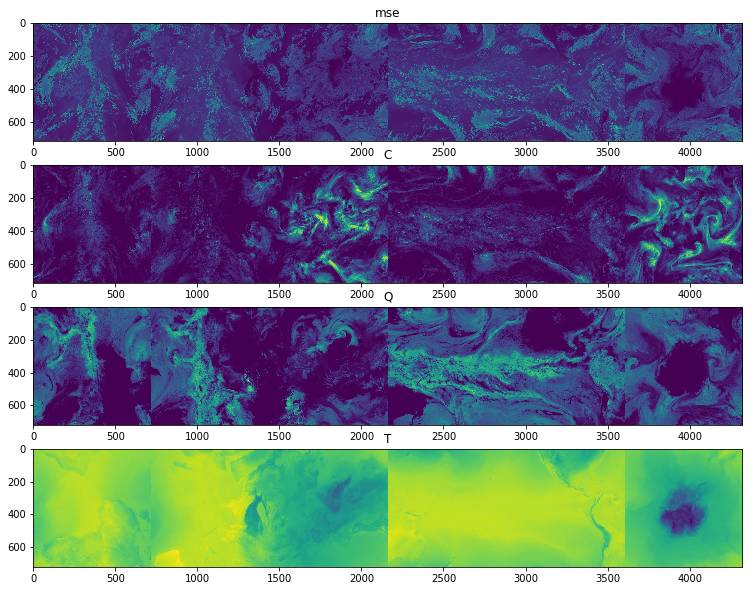

In [32]:
from utils import F_and_plots

F = F_and_plots(shape=(4,1), figsize=(15,10))
F[0].imshow(V); F[0].set_title('mse');
F[1].imshow(C); F[1].set_title('C');
F[2].imshow(Q); F[2].set_title('Q');
F[3].imshow(T); F[3].set_title('T');

In [39]:
print( np.corrcoef(V.flatten(),T.flatten()), '\n', '\n', 
np.corrcoef(V.flatten(),C.flatten()), '\n','\n', 
np.corrcoef(V.flatten(),Q.flatten()) )

[[1.         0.29582476]
 [0.29582476 1.        ]] 
 
 [[1.         0.32681606]
 [0.32681606 1.        ]] 
 
 [[1.        0.1411569]
 [0.1411569 1.       ]]


(720, 4320)


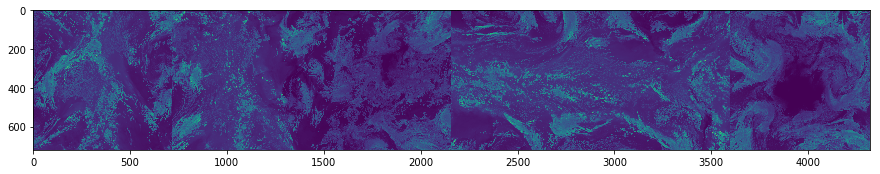

In [10]:
V0 = reconstruct(V, div=5)
f=plt.figure(figsize=(15,10))
plt.imshow(V0)

In [62]:
np.corrcoef(V0.flatten(),T0.flatten())

array([[1.        , 0.40041954],
       [0.40041954, 1.        ]])

In [9]:
def reconstruct(T, div=5):
    _,y,x =T.shape
    T0 = np.zeros((div*x,div*y))
    print(T0.shape)
    for i in range(div):
        for j in range(div):
            if(i*div+j<len(T[:,0])):
                T0[i*x:(i+1)*x, j*y:(j+1)*y] = T[i*div+j].T
    return(T0)

T0 = reconstruct(T)
plt.imshow(T0)

NameError: name 'T' is not defined

In [41]:
T.shape

(24, 864, 144)

In [6]:
import pickle
a = pickle.load( open( Pfile, "rb" ) )

for i,l in enumerate(M.layers[0].layers):
    l.set_weights(a[1][i])
for i,l in enumerate(M.layers[1].layers):
    l.set_weights(a[0][i])

In [7]:
M.load_weights("TrainedModels/20190521221013U.h5")

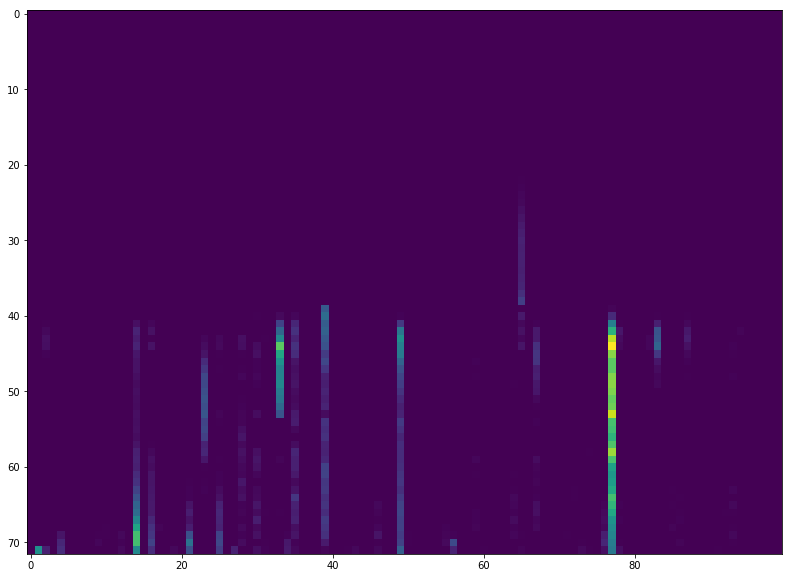

In [30]:
# CHECKING IMPACT OF LOWER LAYER

#o =M.layers[2].get_layer('dense_1').output
i = M_bd_cas.get_input_at(0)
#i  = M.layers[1].get_input_at(1)
o = M_bd_cas.get_output_at(0)
First_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)
o2 = M_unet.get_layer('Reshape').output

o3 = M_unet.get_layer('Conv2_3').get_output_at(0)

Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])

#img = Dense_layer(First_model([x]))[0]
img = Antepen_layer(First_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow(np.mean(img,axis=0))

In [33]:
M.layers[1].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Origin_Input (InputLayer)       (None, 72, 50)       0                                            
__________________________________________________________________________________________________
AVG_1 (AveragePooling1D)        (None, 36, 50)       0           Origin_Input[0][0]               
__________________________________________________________________________________________________
Conv1_1 (Conv1D)                (None, 36, 50)       25050       AVG_1[0][0]                      
__________________________________________________________________________________________________
AVG_2 (AveragePooling1D)        (None, 18, 50)       0           Conv1_1[0][0]                    
__________________________________________________________________________________________________
Conv1_2 (C

In [50]:
(395+250)*25/1000

16.125

In [38]:
w_end = M.layers[1].get_layer('conv1d_1').get_weights()[0][0].T

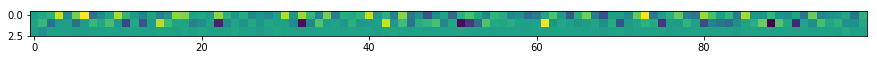

In [39]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow(w_end)

In [46]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten, Input, TimeDistributed, Reshape, Concatenate
from keras.layers import Conv1D, UpSampling1D, AveragePooling1D, SeparableConv1D
from keras import optimizers
from keras.layers import Bidirectional
from keras import backend as K
from keras.losses import mean_squared_error
import keras

from architectures import Bidir_Casual_Conv, Unet, Name
from architectures import flxd_loss, flxu_loss, dfdts_loss, total_loss
from architectures2 import Unet_Act, Activation
from keras import optimizers

from CST import CST


In [48]:
###
Pfile="TrainedModels/20190521221013U.pickle"
list_of_filters_bdc=[[128, 64], [64, 16], [50, 50]]
list_of_kernel_bdc=[[10, 5], [10, 5], [10, 5]]
list_of_filters_unet=[[30, 75, 100], [270], [100, 40, 25]]
list_of_kernel_unet=[[10, 5, 3], [], [5, 8, 12]]

params=[0]
activation_name  = [ ['relu','relu','relu'], ['sigmoid'], ['relu','relu','relu'] ]
M1 =
M2 = Unet(list_of_kernel_unet, list_of_filters_unet, list_of_pooling=[])
M = Sequential()
M.add(M1)
M.add(M2)

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:193: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(9, padding="same", name="AVG_1", strides=2)`
  Poolings_l.append(AveragePooling1D(list_of_kernels_s[0][i]-1, padding='same', stride=2, name=Name('AVG', i+1))(Convs_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:193: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(4, padding="same", name="AVG_2", strides=2)`
  Poolings_l.append(AveragePooling1D(list_of_kernels_s[0][i]-1, padding='same', stride=2, name=Name('AVG', i+1))(Convs_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:193: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_3", strides=2)`
  Poolings_l.append(AveragePooling1D(list_of_kernels_s[0][i]-1, padding='same', stride=2, name=Name('AVG', i+1))(Conv

In [49]:
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Origin_Input (InputLayer)       (None, 72, 11)       0                                            
__________________________________________________________________________________________________
AVG_1 (AveragePooling1D)        (None, 36, 11)       0           Origin_Input[0][0]               
__________________________________________________________________________________________________
Conv1_1 (Conv1D)                (None, 36, 30)       3330        AVG_1[0][0]                      
__________________________________________________________________________________________________
AVG_2 (AveragePooling1D)        (None, 18, 30)       0           Conv1_1[0][0]                    
__________________________________________________________________________________________________
Conv1_2 (C

In [9]:
# IMPORTANT MODEL LOG SAVER
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        for model in models:
            model.summary()
        for k in history.history.keys():
            print(k,':', history.history[k])
        print('\n')
        print('Bdc')
        print('list_of_filters_bdc = ', list_of_filters_bdc)
        print('list_of_kernel_bdc = ', list_of_kernel_bdc)
        print('list_of_activation_bdc = ', list_of_activation_bdc)
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_unet)
        print('list_of_kernel_unet = ',list_of_kernel_unet)
        print('list_of_activation_unet = ', list_of_activation_unet)
        for loss in callback.losses:
            print(loss)

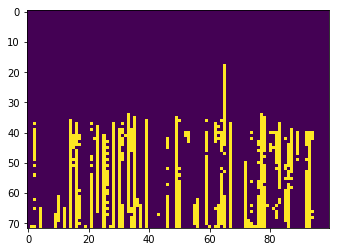

In [46]:
o1=np.zeros((img.shape[1],img.shape[2]))
for i in range(500):
    x,y =validation_generator[i]
    o1 +=abs(Antepen_layer(First_model([x]))[0]).mean(axis=0)
    plt.imshow(o1*0!=o1)

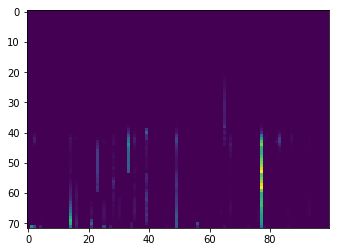

In [47]:
 plt.imshow(o1)

In [15]:
M_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Origin_Input (InputLayer)       (None, 72, 50)       0                                            
__________________________________________________________________________________________________
AVG_1 (AveragePooling1D)        (None, 36, 50)       0           Origin_Input[0][0]               
__________________________________________________________________________________________________
Conv1_1 (Conv1D)                (None, 36, 50)       25050       AVG_1[0][0]                      
__________________________________________________________________________________________________
AVG_2 (AveragePooling1D)        (None, 18, 50)       0           Conv1_1[0][0]                    
__________________________________________________________________________________________________
Conv1_2 (C

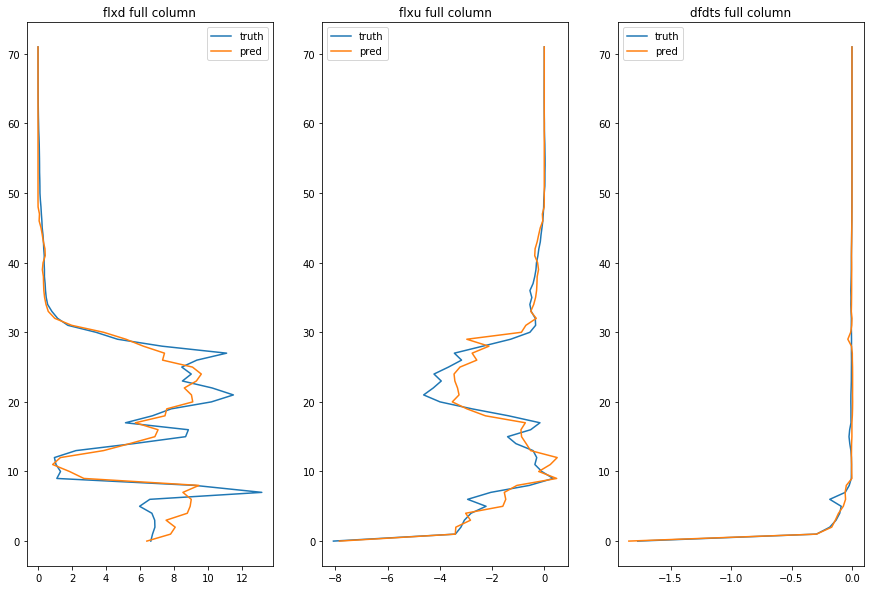

<Figure size 1080x576 with 0 Axes>

In [25]:
from utils import Plot_Batch, Plot_Histograms, Plot_triple_diff_separated, F_and_plots

i=np.random.randint(validation_generator.batch_per_file)

x,y = validation_generator[validation_generator.ids_to_index((0,4,i))]
y0_opred = M.predict(x)
F = F_and_plots(shape=(1,3))
j=0
Plot_triple_diff_separated(F, y, y0_opred, header_y, sep=0, j=j)

In [29]:
#w = M_unet.get_layer('Dense_0').get_weights()
#M_unet.get_layer('Dense_0').set_weights([w[0]*0,w[1]*0])
M_unet.get_layer('Dense_0').set_weights([w[0],w[1]])

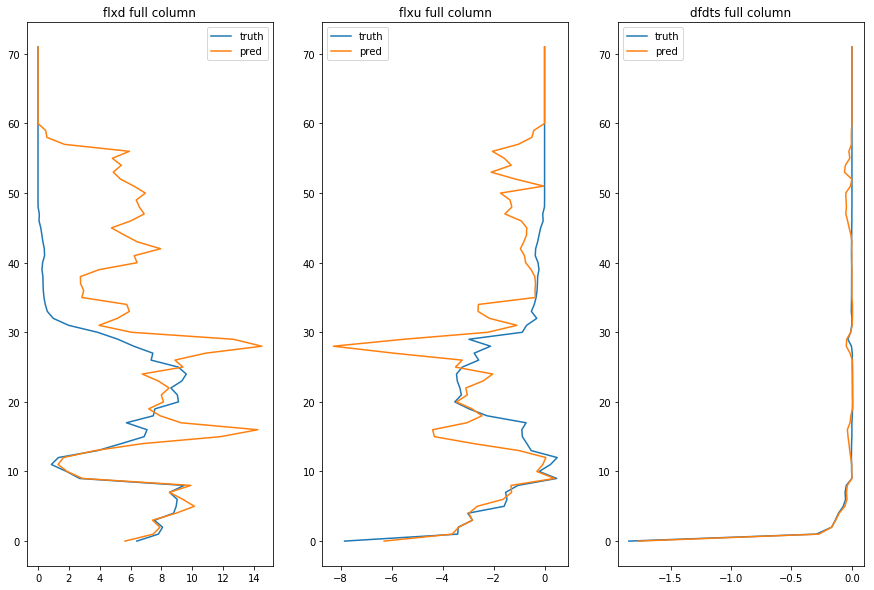

<Figure size 1080x576 with 0 Axes>

In [28]:
y0_0 = M.predict(x)
Plot_triple_diff_separated(F_and_plots(shape=(1,3)), y0_opred, y0_0, header_y, sep=0, j=j)
#M_unet.get_layer('dense_1').set_weights(w)

In [14]:
w[0]

array([[ 0.02674291,  0.03766394,  0.01772979, ..., -0.06652149,
        -0.11078077,  0.00819424],
       [-0.15003423,  0.13728386, -0.02931817, ...,  0.07598945,
        -0.2978172 ,  0.11379563],
       [-0.41257867,  0.2317462 , -0.21195306, ..., -0.12336421,
        -0.01269192,  0.06255825],
       ...,
       [ 0.13406737,  0.10233732,  0.07715214, ...,  0.08939706,
         0.009845  ,  0.30439624],
       [-0.10186556,  0.22354965, -0.00841682, ...,  0.00390028,
         0.30117556,  0.90554607],
       [ 0.10160203, -0.06872793,  0.03889877, ..., -0.02606544,
        -0.15331507,  0.01047357]], dtype=float32)

In [7]:
import time
#full_gen = Up_and_Down_Generator(batch_size=124416)

def Error_on_sets(M, full_gen):
    l=[]
    l_elements=[]
    for x,y in full_gen:
        t=time.time()
        print(full_gen.current_folder, full_gen.current_file)
        l_elements.append( (full_gen.current_folder,full_gen.current_file))
        l.append(K.get_value(total_loss(M.predict(x), y)).mean())
        print(time.time()-t)
    return(l)

#Error_on_sets(M,full_gen)

In [8]:
M = Sequential()
M.add(M_bd_cas)
M.add(M_unet)

In [11]:
N_input = M_bd_cas.get_input_at(1) #Input( shape=(72, in_channel))
#Inter_m = M_bd_cas.get_output_at(0)
#N_output = M_unet(Inter_m)
#M =keras.Model( N_input, N_output)

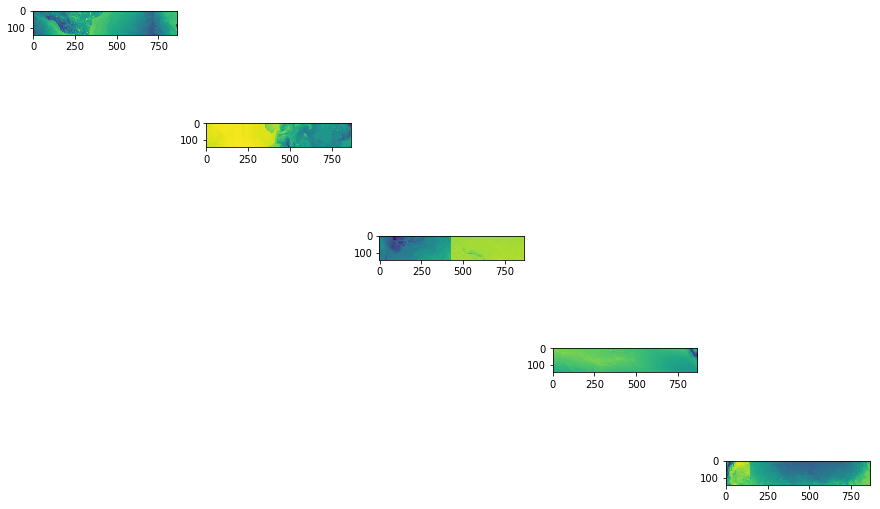

In [9]:
# SHOW THAT WE ARE MISSING VALUES
B = Basic_Generator(batch_size=124416, shuffle=0)
B.current_file
B.current_folder
f = plt.figure(figsize=(15,10))
for i in range(5):
    X1,Y = B.load_a_couple(B.load_a_path(1,i))
    X,Y = B.load_a_couple(B.load_a_path(0,i))
    TS = np.array(X1['ts']).reshape(B.Ydim, B.Xdim, 72)[:,:,-1]# -np.array(X['ts']).reshape(B.Ydim, B.Xdim, 72)[:,:,-1]
    plt.subplot(5,5, 1+6*i)
    plt.imshow(TS.T)

In [4]:
import pickle
seed=0

def Save_Models_asPickle(Mlist, name):
    W0 = []
    for m in Mlist:
        w=[]
        for layer in m.layers:
            w.append(layer.get_weights())
        W0.append(w.copy())
    with open(name, 'wb') as f:
        pickle.dump(W0, f)
    return(W0)

Save_Models_asPickle([ M_bd_cas, M_unet], os.path.join(model_folder, prefix+archi+'.pickle'))
Generate_Log([M, M_unet, M_bd_cas], history, LH, os.path.join(log_folder,prefix+archi+'.txt'), seed)
file = os.path.join(log_folder,prefix+archi+'.txt')

models = [M, M_bd_cas, M_unet]
callback = LH
# Generate the structure of the net with the log
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        for model in models:
            model.summary()
        for k in history.history.keys():
            print(k,':', history.history[k])
        print('\n')
        print('Bdc')
        print('list_of_filters_bdc = ',list_of_filters_bdc)
        print('list_of_kernel_bdc = ',list_of_kernel_bdc)
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_unet)
        print('list_of_kernel_unet = ',list_of_kernel_unet)
        for loss in callback.losses:
            print(loss)

NameError: name 'M_bd_cas' is not defined

In [20]:
X = np.array(B.X['pl'])

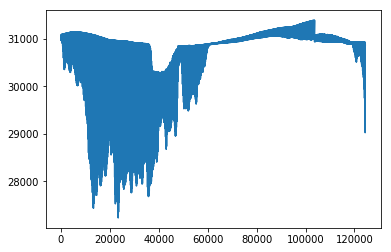

In [27]:
plt.plot(np.mean(X, axis=1))

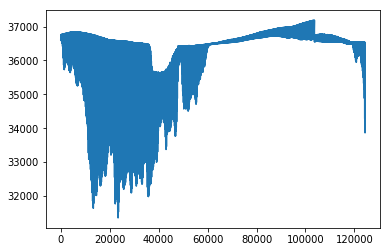

In [25]:
plt.plot(np.std(X, axis=1))

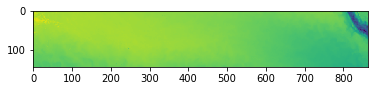

In [45]:
X,Y = B.load_a_couple(B.load_a_path(3,3))
TS = np.array(X['ts']).reshape(B.Ydim, B.Xdim, 72)[:,:,1]
plt.imshow(TS.T)

In [28]:
def total_loss(y_true, y_pred):
    E = flxd_loss(y_true, y_pred)
    E += flxu_loss(y_true, y_pred)
    E += dfdts_loss(y_true, y_pred)
    return E
x,y = train_generator[0]


In [33]:
l = K.get_value(total_loss(M.predict(x),y))

In [23]:
print(B.Xdim, B.Ydim)

144 864


In [18]:
from architectures import Name, Averaged_Bidir
train_generator =  FC_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, custom_b_p_e=50)
validation_generator =  FC_Generator(folder=data_folder, batch_size=5*batch_size, train=False, preprocess_x=FP, custom_b_p_e = 50)

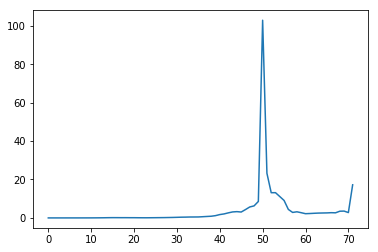

In [19]:
x,y = train_generator[0]
plt.plot(y[0,:72])

([<matplotlib.lines.Line2D at 0x7f0a0d3edf98>],)

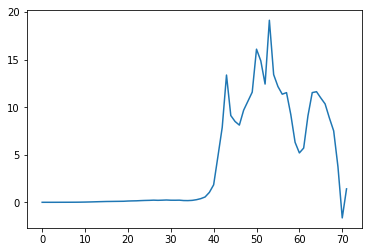

In [14]:
plt.plot( y[0, np.array([3*i for i in range(72)])]),

In [4]:
# NEW MODEL :
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten, Input, TimeDistributed, Concatenate, Input
from keras.layers import Conv1D, UpSampling1D, AveragePooling1D, SeparableConv1D, Lambda, Reshape
from keras.layers import Bidirectional
from keras.losses import mean_squared_error
from keras import backend as K

## New Archs

In [1]:
from keras.layers import LeakyReLU, Activation, ELU

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [8]:
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten, Input, TimeDistributed, Concatenate
from keras.layers import Conv1D, UpSampling1D, AveragePooling1D, SeparableConv1D
from keras.layers import Bidirectional, Lambda, Reshape
from keras.losses import mean_squared_error
from keras import backend as K
from keras import regularizers

from architectures import Name

def Bidir_Casual_Conv2(list_of_kernel_s, list_of_filters, ups, pooling, in_channel, o_channel, lev=CST.lev(CST)):
    """
    used as input for the Unet
    """
    Input0 = Input(shape=(lev, in_channel), name=Name('Input',0), dtype='float32')

    Flip_layer = lambda x: K.reverse(x, axes=0)
    I_cp = UpSampling1D(ups, name=Name('Up',0))(Input0)
    I_avg = AveragePooling1D(pooling, padding='same', stride=ups, name='AVG_p')(I_cp)
    I_avg_flip = Lambda(Flip_layer, name=Name('Flip',0))(I_avg)

    Conv1u = []
    Conv1d = []
    ACTu = [I_avg]
    ACTd = [I_avg_flip]
    ACTc = []
    # Normal
    for i in range(len(list_of_filters[0])):
        Conv1u.append(Conv1D(filters = list_of_filters[0][i], kernel_size= list_of_kernel_s[0][i], \
                        padding='causal', name=Name("Conv_u",i+1), use_bias=True)(ACTu[-1]))
        ACTu.append(LeakyReLU(alpha=0.3)(Conv1u[-1]) )
    # Flipped
    for i in range(len(list_of_filters[1])):
        Conv1d.append(Conv1D(filters = list_of_filters[1][i], kernel_size= list_of_kernel_s[1][i],\
                        padding='causal', name=Name("Conv_d",i+1), use_bias=True)(ACTd[-1]))
        ACTd.append(LeakyReLU(alpha=0.3)(Conv1d[-1]) )

    C_flip = Lambda(Flip_layer,name=Name('Flip',1))(ACTd[-1])
    C1d_prime = []
    ACTc = [Concatenate( name=Name('Concat',0))([ACTu[-1], C_flip])]
    for i in range(len(list_of_filters[2])):
        if i==len(list_of_kernel_s)-1:
            C1d_prime.append(Conv1D(filters = list_of_filters[2][i], kernel_size=list_of_kernel_s[2][i], \
                            padding='causal', name=Name("Conv_conc",i), use_bias=False)(ACTc[-1]))
        else:
            C1d_prime.append(Conv1D(filters = list_of_filters[2][i], kernel_size=list_of_kernel_s[2][i], \
                            padding='causal', name=Name("Conv_conc",i), use_bias=False)(ACTc[-1]))
            ACTc.append(LeakyReLU(alpha=0.3)(C1d_prime[-1]) )
    return keras.Model(Input0, C1d_prime[-1])

inter_channel=50
ups=5
pooling=22
in_channel=10
o_channel=3
list_of_filters_bdc = [[64, 32],[32, 20],[10,inter_channel]]
list_of_kernel_bdc = [[10,5],[10,5],[2,5]]
M_bd_cas = Bidir_Casual_Conv2(list_of_kernel_bdc, list_of_filters_bdc, ups, pooling, in_channel, o_channel=inter_channel, lev=CST.lev(CST))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", name="AVG_p", strides=5)`


In [3]:
def Unet2(list_of_kernels_s, list_of_filters, list_of_pooling, Div=3, lev=CST.lev(CST), in_channel=11, o_channel=CST.output_y(CST)):
    """
    Generate a Unet-Archictecture
    list_of_kernels : list of 2 lists containing the kernel size for convolution
    list_of_filters : list of 2 lists containing the number of filters for convolution
    Div : number of downscaling
    in_channel : number of inputs
    """
    Concats_l = []
    Upsamplings_l = []
    Convs_l1 = []
    Convs_l2 = []
    Poolings_l = []

# DownScaling
    ACT_l1 = [] 
    ACT_l1.append(Input(name = 'Origin_Input',  dtype='float32', shape=(lev, in_channel)))

    for i in range(Div):
        Poolings_l.append(AveragePooling1D(list_of_kernels_s[0][i]-1, padding='same', \
                                           stride=2, name=Name('AVG', i+1))(ACT_l1[-1]))
        Convs_l1.append(Conv1D(filters=list_of_filters[0][i], kernel_size=list_of_kernels_s[0][i], \
                                padding='same', activation='relu', name=Name('Conv1',i+1))( Poolings_l[-1] ))
        ACT_l1.append(LeakyReLU(alpha=0.3)(Convs_l1[-1]) )
        
# Operation done on the small dimension : here fc
    Convs_l2.append(Flatten()(Convs_l1[-1])  )
    Convs_l2.append(Dense( int(lev/2**Div) * list_of_filters[1][0]  )(Convs_l2[-1])  )
    Convs_l2.append(Reshape(name='Reshape',input_shape=Convs_l2[-1].shape ,\
                            target_shape=( int(lev/2**Div)  ,  list_of_filters[1][0] ))(Convs_l2[-1]))

# Upsampling and concats
    for i in range(Div):
        Concats_l.append(Concatenate( name=Name('Concat',i+1) )([Convs_l2[-1], Convs_l1[-i-1]]))
        Upsamplings_l.append(UpSampling1D(2, name=Name('Ups',i+1))(Concats_l[-1]))
        Convs_l2.append(Conv1D(filters=list_of_filters[2][i], kernel_size=list_of_kernels_s[2][i], \
                                padding='same', activation='relu', name=Name('Conv2',i+1))( Upsamplings_l[-1] ))
    Conv3 = Conv1D(filters=o_channel, kernel_size=1, padding='same', use_bias=False)(Convs_l2[-1])
    return keras.Model(Convs_l1[0],Conv3)
###### FC
        
list_of_filters_unet = [[50,75,100],[30*9],[50,75,100]]
list_of_kernel_unet = [[10,5,3],[],[10,5,3]]
M_unet = Unet(list_of_kernel_unet, list_of_filters_unet, [], Div=3, lev=72, in_channel=inter_channel, o_channel=o_channel)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", name="AVG_p", strides=5)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", name="AVG_1", strides=2)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", name="AVG_2", strides=2)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", name="AVG_3", strides=2)`


In [91]:
M_bd_cas.summary()
M_unet.summary()
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_0 (InputLayer)            (None, 72, 11)       0                                            
__________________________________________________________________________________________________
Up_0 (UpSampling1D)             (None, 360, 11)      0           Input_0[0][0]                    
__________________________________________________________________________________________________
AVG_p (AveragePooling1D)        (None, 72, 11)       0           Up_0[0][0]                       
__________________________________________________________________________________________________
Flip_0 (Lambda)                 (None, 72, 11)       0           AVG_p[0][0]                      
__________________________________________________________________________________________________
Conv_d_1 (

In [92]:
from architectures import FC_archi, LossHistory, Generate_Log, Bidir_Causal_Conv
from architectures import total_loss, flxd_loss, flxu_loss, dfdts_loss

from keras import optimizers
import datetime

prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "FC"

LH = LossHistory()
rmsprop = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=1.e-6)

M.compile(loss=total_loss, optimizer=rmsprop, metrics=[flxd_loss,flxu_loss, dfdts_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 72, 11)            0         
_________________________________________________________________
model_58 (Model)             (None, 72, 50)            37148     
_________________________________________________________________
model_59 (Model)             (None, 72, 3)             2525805   
Total params: 2,562,953
Trainable params: 2,562,953
Non-trainable params: 0
_________________________________________________________________


In [12]:
import datetime
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
prefix

'20190522092804'

In [94]:
history = M.fit_generator(generator=train_generator ,
                    validation_data=validation_generator,
                             shuffle=False,
                               callbacks = [LH],
                               epochs=5,
                               verbose=1)

Epoch 1/5
50/50 [==============================] - 2s 34ms/step - loss: 55.9842 - flxd_loss: 22.6528 - flxu_loss: 9.8554 - dfdts_loss: 23.4761 - val_loss: 92.9883 - val_flxd_loss: 40.0046 - val_flxu_loss: 20.7489 - val_dfdts_loss: 32.2348
Epoch 2/5
50/50 [==============================] - 2s 42ms/step - loss: 88.1496 - flxd_loss: 40.9161 - flxu_loss: 17.9249 - dfdts_loss: 29.3087 - val_loss: 156.0247 - val_flxd_loss: 63.6718 - val_flxu_loss: 20.9958 - val_dfdts_loss: 71.3571
Epoch 3/5
50/50 [==============================] - 2s 43ms/step - loss: 84.5464 - flxd_loss: 39.6247 - flxu_loss: 16.4422 - dfdts_loss: 28.4796 - val_loss: 87.3460 - val_flxd_loss: 49.8442 - val_flxu_loss: 23.3267 - val_dfdts_loss: 14.1751
Epoch 4/5
50/50 [==============================] - 2s 42ms/step - loss: 138.8627 - flxd_loss: 63.9523 - flxu_loss: 21.5279 - dfdts_loss: 53.3825 - val_loss: 130.6837 - val_flxd_loss: 60.3368 - val_flxu_loss: 20.5891 - val_dfdts_loss: 49.7579
Epoch 5/5
50/50 [=====================

68040

In [28]:
M.summary()
x,y = train_generator[0]
x2,y = train_generator[0]

x3 = np.concatenate((x,x), axis=0)
M.predict(x3).shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_0 (InputLayer)            (None, 72, 11)       0                                            
__________________________________________________________________________________________________
Up_0 (UpSampling1D)             (None, 360, 11)      0           Input_0[0][0]                    
__________________________________________________________________________________________________
AVG_p (AveragePooling1D)        (None, 72, 11)       0           Up_0[0][0]                       
__________________________________________________________________________________________________
Flip_0 (Lambda)                 (None, 72, 11)       0           AVG_p[0][0]                      
__________________________________________________________________________________________________
Conv_d_0 (

(128, 72, 50)

In [2]:
1.e-6*68040

0.06804

In [23]:
from keras.utils import plot_model
plot_model(M, to_file='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [8]:
# IMPORTANT LOADING ARCHITECTURES AND WEIGHTS OF THE FIRST TRYES (METHODOLOGY WAS NOT STANDARDISE YET)
# SOMETIMES THE LAST MODEL IS SAVED INSTEAD OF THE 
from architectures import Classical_Bidir, Old_Bidir, Add_Upsampling, Upsampler
from architectures import flxd_loss, flxu_loss, dfdts_loss, total_loss
from architectures import Weird_Averaged_Bidir, Averaged_Bidir

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten, Input, TimeDistributed
from keras.layers import Conv1D, UpSampling1D, AveragePooling1D, SeparableConv1D
from keras.layers import Bidirectional
from keras.losses import mean_squared_error
from keras import optimizers

n_channel = len(train_generator.variables)
o_channel = len(train_generator.new_variables_pred)
shape = (72,n_channel)

m_old = Old_Bidir()

model_bd = Weird_Averaged_Bidir(in_channel=n_channel, out_channel=o_channel)
model_bd_2 = Add_Upsampling(model_bd, shape, 5, 26)

model_bd_avg = Averaged_Bidir(in_channel=n_channel, out_channel=o_channel)
model_bd_avg_2 = Add_Upsampling(model_bd_avg, shape, 5, 26)

Model0_w = os.path.join(model_folder,'20190514234805Bidir.h5')  # Old one
Model1_w = os.path.join(model_folder,'20190515175543Bidir.h5') # With not so weird avg
Model2_w = os.path.join(model_folder,'20190515213039_2Bidir.h5') # 2 epoch "normal" avg

# Only one part was loaded
m_old.load_weights(Model0_w)
m_old_2 = Add_Upsampling(m_old, shape, 5, 26)

model_bd.load_weights(Model1_w)
model_bd_avg_2.load_weights(Model2_w)

# OK
model_bd_2 = Add_Upsampling(model_bd, shape, 5, 26)

model_bd_2.summary()
model_bd_avg_2.summary()

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1.e-5)
model_bd_2.compile(loss=total_loss, optimizer=rmsprop,  metrics=[flxd_loss,flxu_loss, dfdts_loss])
model_bd_avg_2.compile(loss=total_loss, optimizer=rmsprop,  metrics=[flxd_loss,flxu_loss, dfdts_loss])

prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "Bidir"
model_bd.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:89: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(7, padding="same", strides=1)`
  modelbd.add(AveragePooling1D(7, padding='same', stride=1))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:92: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(4, padding="same", strides=1)`
  modelbd.add(AveragePooling1D(4, padding='same', stride=1))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:103: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(26, padding="same", strides=5)`
  M.add(AveragePooling1D(pooling, padding='same', stride=avg))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         (None, 72, 11)            0         
_________________________________________________________________
Upsampler (Sequential)       (None, 72, 11)            0         
_________________________________________________________________
Sequential_1 (Sequential)    (None, 72, 3)             260369    
Total params: 260,369
Trainable params: 260,369
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         (None, 72, 11)            0         
_________________________________________________________________
Upsampler (Sequential)       (None, 72, 11)            0         
_________________________________________________________________
Sequ

### VISUALISATION OF A FEW PREDICTION

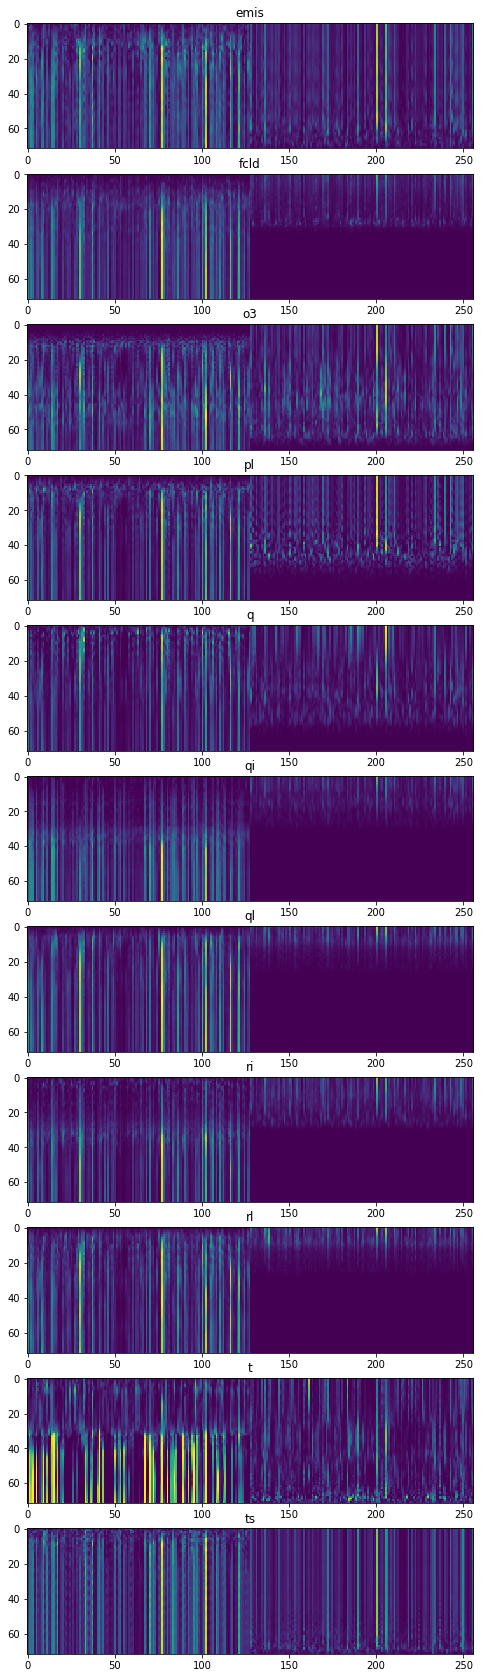

In [75]:
x, y = validation_generator[40]
get_bidir_layer_output = K.function([model_bd_avg.layers[0].input],
                                  [model_bd_avg.layers[0].output])
X=[x.copy()]
for i in range(11):
    X.append(x.copy())
    X[i] *= 0
    X[i][:,:,i] = x[:,:,i]
#    if(i==3):
#        X[i][:,:41, 3]=0

layer_output = [ get_bidir_layer_output([xi]) for xi in X]
F = F_and_plots(shape=(11,1), figsize=(20, 30))
for i in range(11):
    img = np.flip(np.mean(abs(layer_output[i][0]), axis=0))
    F[i].set_title(header_x[i])
    F[i].imshow(img)

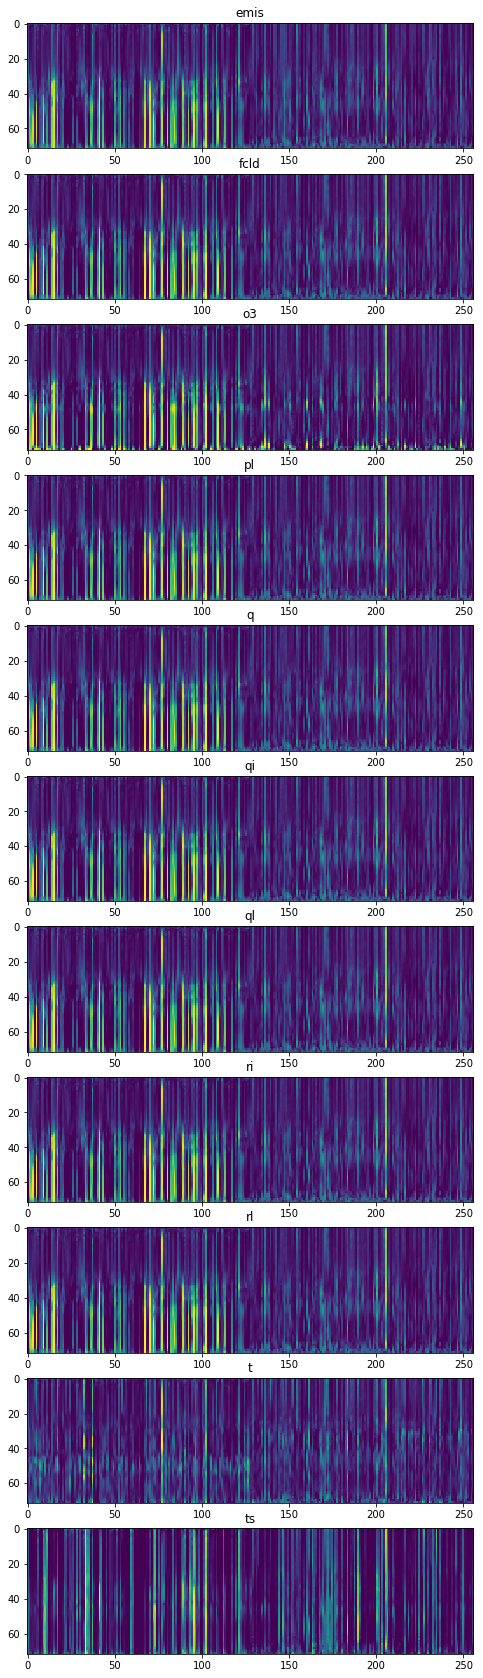

In [107]:
x, y = validation_generator[400]
get_bidir_layer_output = K.function([model_bd_avg.layers[0].input],
                                  [model_bd_avg.layers[0].output])
X=[x.copy()]
for i in range(11):
    X.append(x.copy())
#    X[i] *= 0
    X[i][:,:,i] *= x[:,:,i]
#    if(i==3):
#        X[i][:,:41, 3]=0

layer_output = [ get_bidir_layer_output([xi]) for xi in X]
F = F_and_plots(shape=(11,1), figsize=(20, 30))
for i in range(11):    
    img = np.flip(np.mean(abs(layer_output[i][0]), axis=0))
    F[i].set_title(header_x[i])
    F[i].imshow(img)

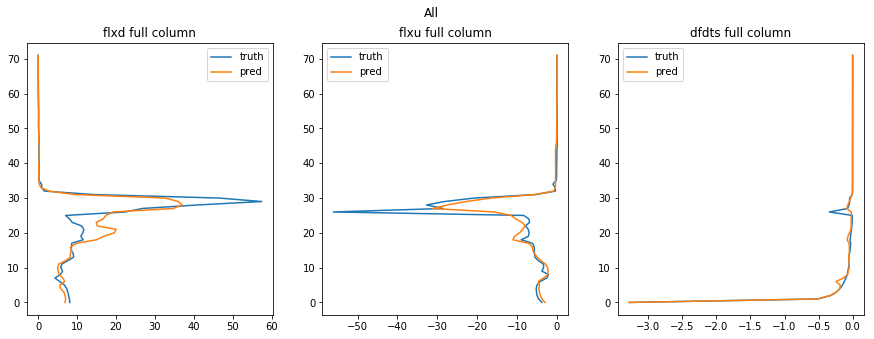

<Figure size 1080x576 with 0 Axes>

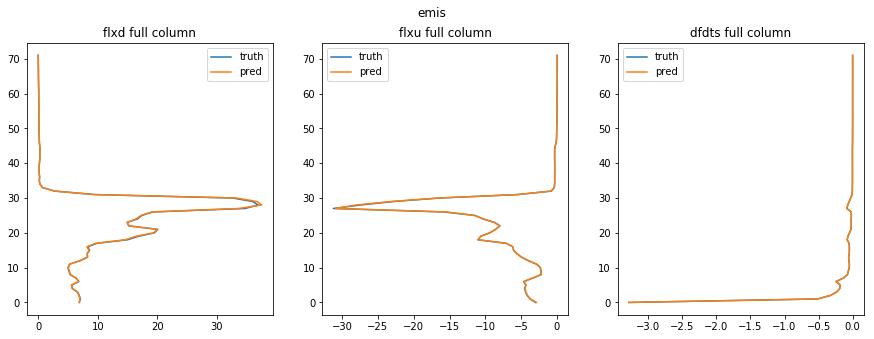

<Figure size 1080x576 with 0 Axes>

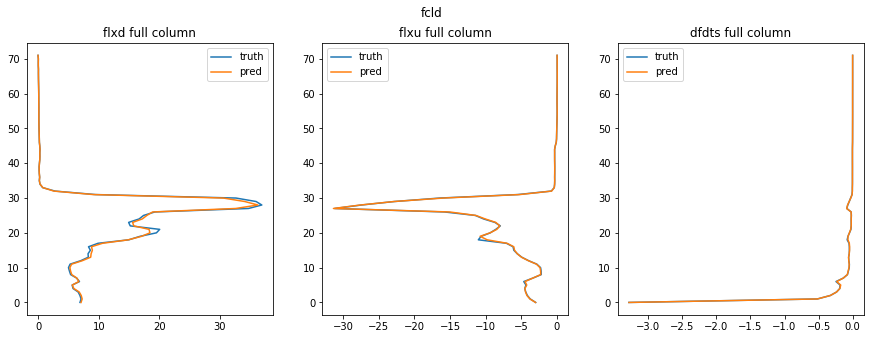

<Figure size 1080x576 with 0 Axes>

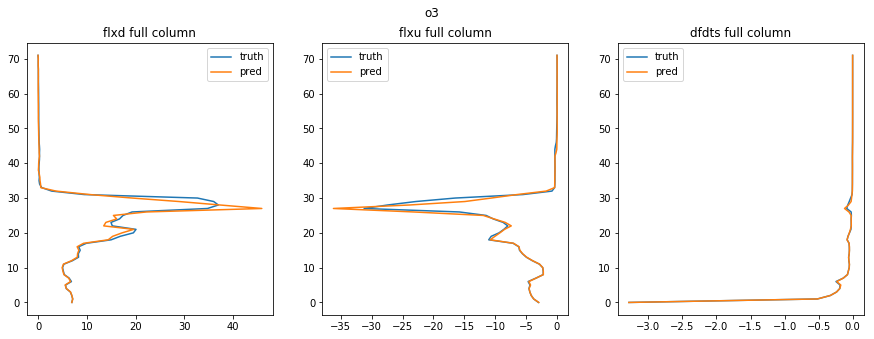

<Figure size 1080x576 with 0 Axes>

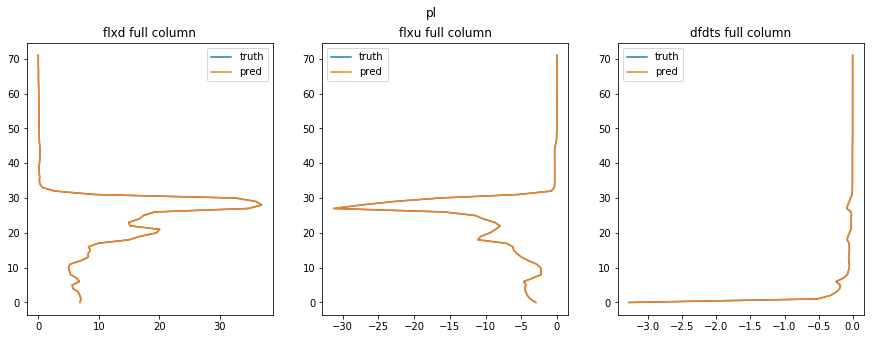

<Figure size 1080x576 with 0 Axes>

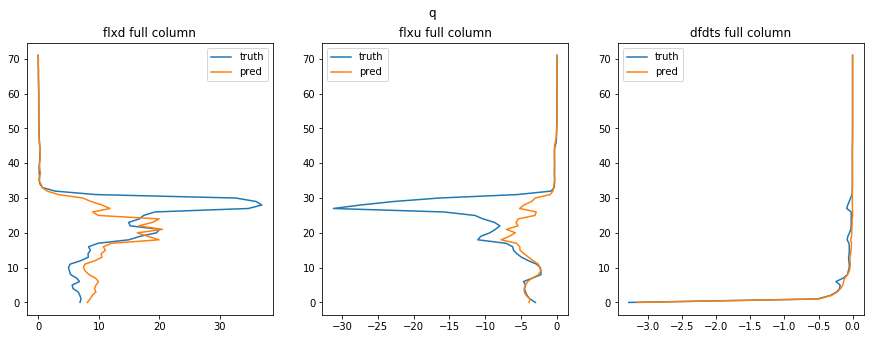

<Figure size 1080x576 with 0 Axes>

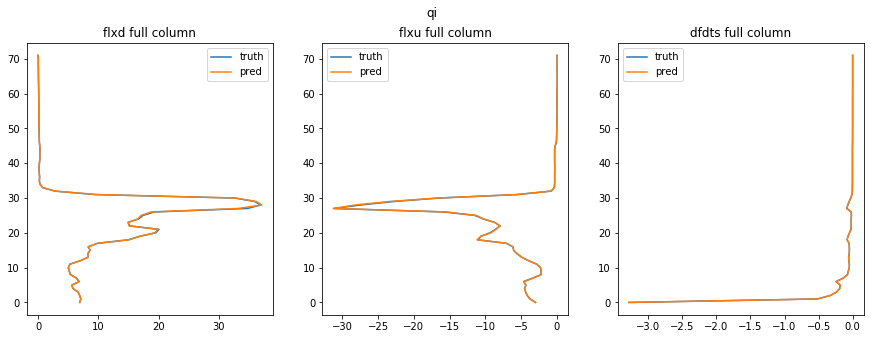

<Figure size 1080x576 with 0 Axes>

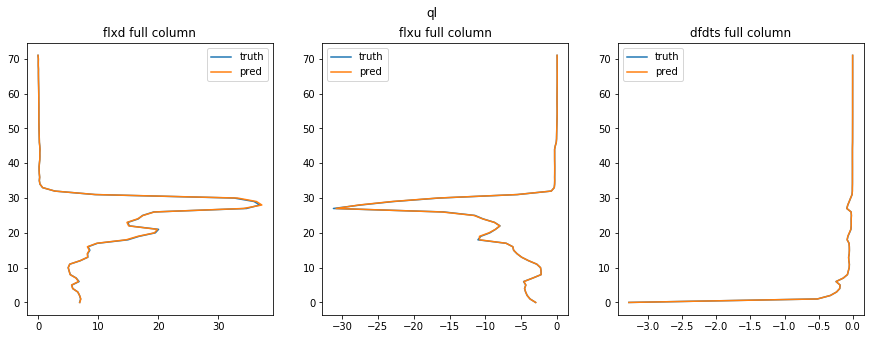

<Figure size 1080x576 with 0 Axes>

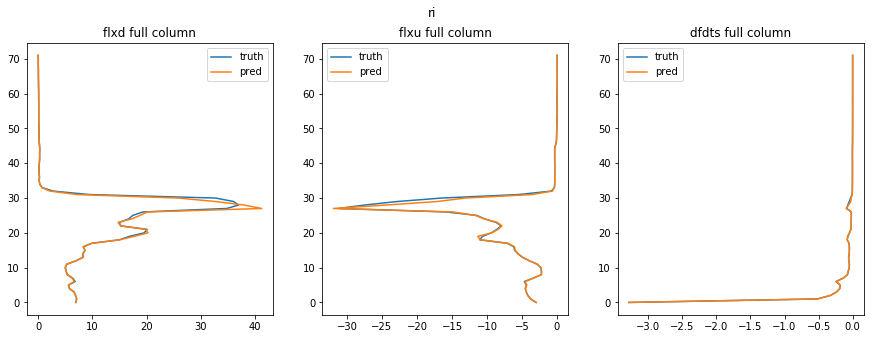

<Figure size 1080x576 with 0 Axes>

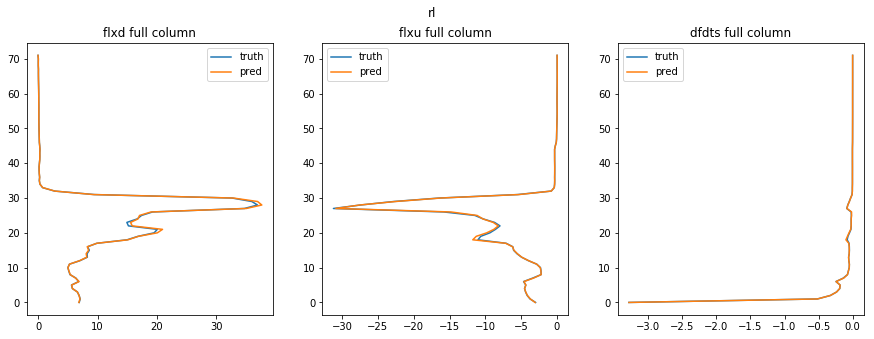

<Figure size 1080x576 with 0 Axes>

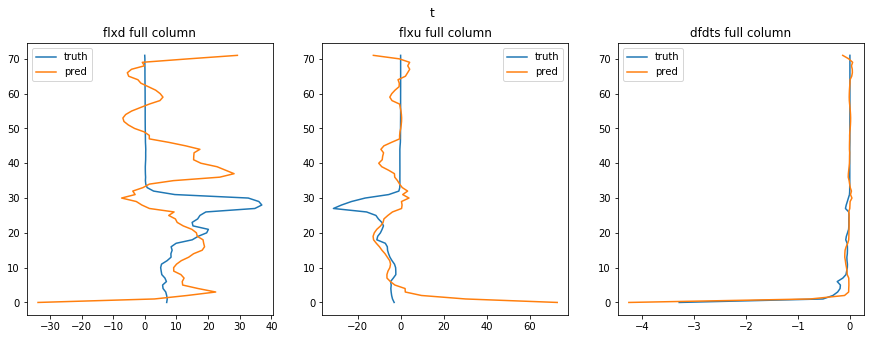

<Figure size 1080x576 with 0 Axes>

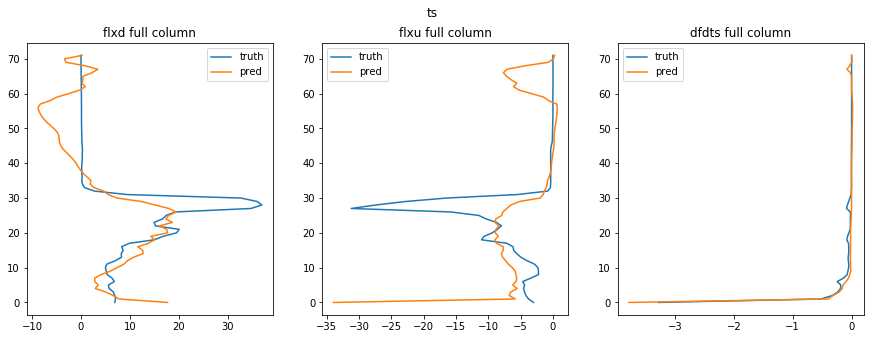

<Figure size 1080x576 with 0 Axes>

In [116]:
y_pred = []
y0 = model_bd_avg_2.predict(x)
F = F_and_plots((1,3), figsize=(15,5))
F.f.suptitle("All")
j=60
Plot_triple_diff_separated(F  , y, y0, header_y, sep=0, j=j)
for i in range(11):
    y_pred.append(model_bd_avg_2.predict(X[i]))
    F = F_and_plots((1,3), figsize=(15,5))
    F.f.suptitle(header_x[i])
    Plot_triple_diff_separated(F  , y0, y_pred[i],header_y, sep=0, j=j)

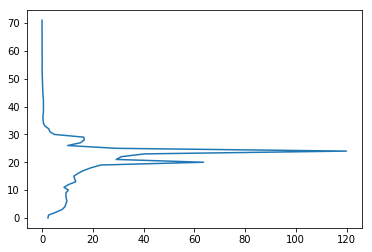

In [7]:
from generator import Full_Diff_Generator
FDG = Full_Diff_Generator(chosen_var=['flxu', 'flxd', 'dfdts', 'flx'])
x,y = FDG[0]

def Plot_one_profile(y):
    plt.plot(np.flip(y).T, np.arange(len(y[0])) )
    plt.show()

from generator import FC_Generator
from architectures import FFC_archi

FC_g = FC_Generator(preprocess_x=D)
x,y = FC_g[0]
M=FFC_archi(ups, pooling, [520, 128, 50, 128, 3*72] ,64)
ts = x[1][:,-1].reshape(-1,1)
w,b = M.get_layer('Dense_0').get_weights()
M.get_layer('Dense_0').set_weights( [w*0 ,b] )
w,b = M.get_layer('Dense_0').get_weights()
W0 = w.copy()
#W0[:,-3] = 100
#W0[:,-2] = -100
W0[-1,5] = -1
M.get_layer('Dense_0').set_weights( [W0 ,b] )    

Plot_one_profile( y[[1],:,1] -y[[1],:,0])

In [51]:
# Compute df/dts for the batch x_test

x_test,y = validation_generator[0]
k_constants = K.constant(x_test[:,:,:-1])
input11 = keras.layers.Input(batch_shape=(64,1))
input12 = keras.layers.RepeatVector(n=72)(input11)
out11 = keras.layers.Lambda(lambda x: K.concatenate([x,k_constants],axis=-1))(input12)
out12 = model_bd_avg_2(out11)
out13 = keras.layers.Lambda(lambda y: y[:,:,1] - y[:,:,0])(out12)
model1 = keras.models.Model(inputs=input11, outputs=out13)
model1.summary()
###
import time
t=time.time()
gradients = [K.gradients(model1.get_output_at(0)[:,i], model1.input) for i in range(72)]
grad0 = K.function( [model1.input] , [gradients[i][0] for i in range(72)] )
ts = x_test[:,0,-1].reshape(x_test.shape[0], 1)
g = np.array(grad0([ts]))
g = g.swapaxes(0,1)
print(time.time()-t)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 1)                   0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (64, 72, 1)               0         
_________________________________________________________________
lambda_1 (Lambda)            (64, 72, 11)              0         
_________________________________________________________________
model_2 (Model)              multiple                  260369    
_________________________________________________________________
lambda_2 (Lambda)            (64, 72)                  0         
Total params: 260,369
Trainable params: 260,369
Non-trainable params: 0
_________________________________________________________________
119.60348534584045


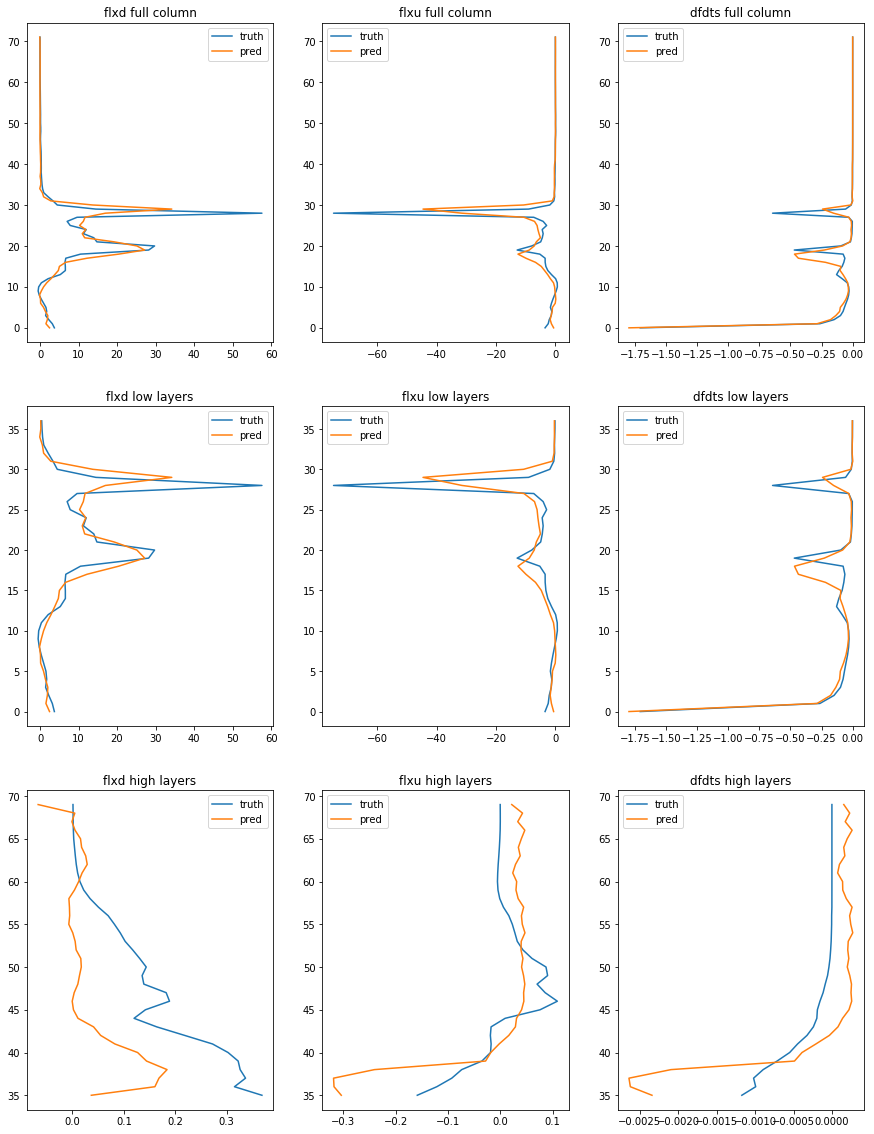

<Figure size 1080x576 with 0 Axes>

In [8]:
from utils import Plot_Batch, Plot_Histograms, Plot_triple_diff_separated, F_and_plots

x,y = validation_generator[10]
#x_t = K.placeholder(shape=(64,72,11))
y0 = model_bd_avg_2.predict(x)
#y1 = model_bd_2.predict(x)

Plot_triple_diff_separated(F_and_plots((3,3), figsize=(15,20)), y,y0, header_y, sep=35, j=0)
#Plot_triple_diff_separated(F_and_plots((3,3), figsize=(15,20)), y,y1, header_y, sep=35, j=0)

In [99]:
x, y_true = validation_generator[1000]

def RMSE(model, x,y_true):
    y_pred = model.predict(x)
    rmse = np.sqrt(np.mean(K.get_value(flxd_loss(y_true, y_pred))))
    return(rmse)

RMSE(model_bd_avg_2, x, y_true)

4.443995

In [104]:
x,y = B[50]
for i in range(x.shape[0]):
    print(x[i,-1,-1], x[i,-1,-2])
#    np.corrcoef(x[:,0,-1], x[:,0,-2])

302.0666 302.0666
271.97787 271.97787
263.91922 263.91922
261.99637 261.99637
253.14119 253.14119
303.28918 303.28918
301.06747 301.06747
302.89963 302.89963
302.33746 302.33746
304.00885 304.00885
301.33936 301.33936
301.74155 301.74155
267.00882 267.00882
262.3604 262.3604
303.11652 303.11652
272.66788 272.66788
301.39795 301.39795
247.6201 247.6201
284.18243 284.18243
296.40894 296.40894
300.9402 300.9402
300.83997 300.83997
301.96887 301.96887
302.2636 302.2636
300.32568 300.32568
302.88705 302.88705
259.71283 259.71283
301.29825 301.29825
301.58328 301.58328
272.37985 272.37985
260.19626 260.19626
301.82382 301.82382
302.06876 302.06876
257.9679 257.9679
302.69415 302.69415
297.52536 297.52536
260.9577 260.9577
248.81042 248.81042
302.12387 302.12387
302.48624 302.48624
301.956 301.956
262.1444 262.1444
275.39362 275.39362
302.2984 302.2984
268.12494 268.12494
266.11087 266.11087
303.02536 303.02536
277.54776 277.54776
302.9886 302.9886
302.3208 302.3208
304.11383 304.11383
248.51

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:125: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", name="AVG_1", strides=5)`
  o2 = AveragePooling1D(pooling, padding='same', stride=ups, name=Name('AVG',1))(o1)


In [8]:
x,y = validation_generator[1]
x_t = K.placeholder(shape=(64,72,11))
y1 = mold.predict(x)
y2 = mold2.predict(x)
y3 = modelbd.predict(x)
y4 = modelbd2.predict(x)

In [9]:
x,y = validation_generator[np.random.randint(500)]

input1 = modelbd2.input
output1 = modelbd2.layers[1].get_output_at(-1)
#output = modelbd2.layers[0].output
#input2 = modelbd2.layers[0].input
outputs = modelbd.layers[0].output

functor = K.function( [input1], [outputs] )
functor([x_t])

InvalidArgumentError: You must feed a value for placeholder tensor 'Bidir_input' with dtype float and shape [?,72,11]
	 [[Node: Bidir_input = Placeholder[dtype=DT_FLOAT, shape=[?,72,11], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Bidir/concat/_205 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_414_Bidir/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [362]:
from generator import Preprocessed_Generator
P = Preprocessed_Generator(preprocess_x=D)

In [361]:
D

In [90]:
model_one_dir_up  = keras.models.clone_model(modelbd)
model_one_dir_down  = keras.models.clone_model(modelbd)
for i,layer in enumerate(modelbd.layers):
    model_one_dir_up.layers[i].set_weights(layer.get_weights())
    model_one_dir_down.layers[i].set_weights(layer.get_weights()) 

In [97]:
W = modelbd.layers[1].get_weights()[0]
Set_0_up = np.concatenate( (W[:,:128] , W[:,128:]*0), axis=1)
Set_0_down = np.concatenate( (W[:,:128]*0 ,W[:,128:]), axis=1)
model_one_dir_up.layers[1].set_weights( [Set_0_up])
model_one_dir_down.layers[1].set_weights( [Set_0_down])

In [98]:
x,y = validation_generator[0]
y_p1 = modelbd.predict(x)
y_p2 = model_one_dir_up.predict(x)
y_p3 = model_one_dir_down.predict(x)

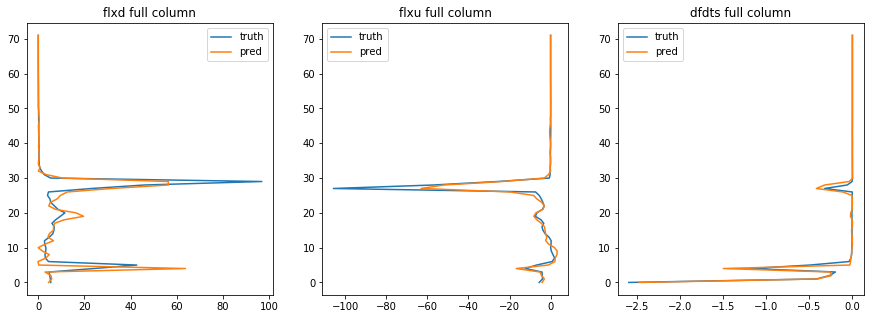

<Figure size 1080x576 with 0 Axes>

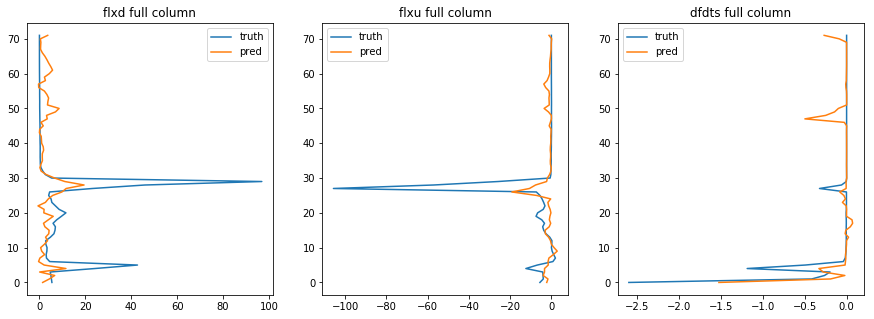

<Figure size 1080x576 with 0 Axes>

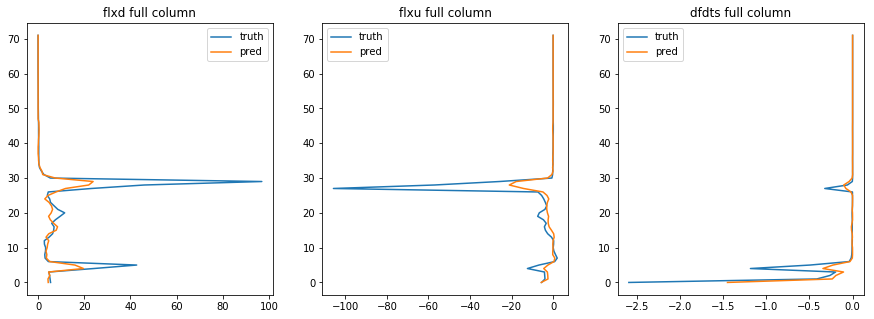

<Figure size 1080x576 with 0 Axes>

In [103]:
Show_triple_diff_separated(F_and_plots((1,3), figsize=(15,5)), y, y_p1, header_y, sep=0, j=1)
Show_triple_diff_separated(F_and_plots((1,3), figsize=(15,5)), y, y_p2, header_y, sep=0, j=1)
Show_triple_diff_separated(F_and_plots((1,3), figsize=(15,5)), y, y_p3, header_y, sep=0, j=1)

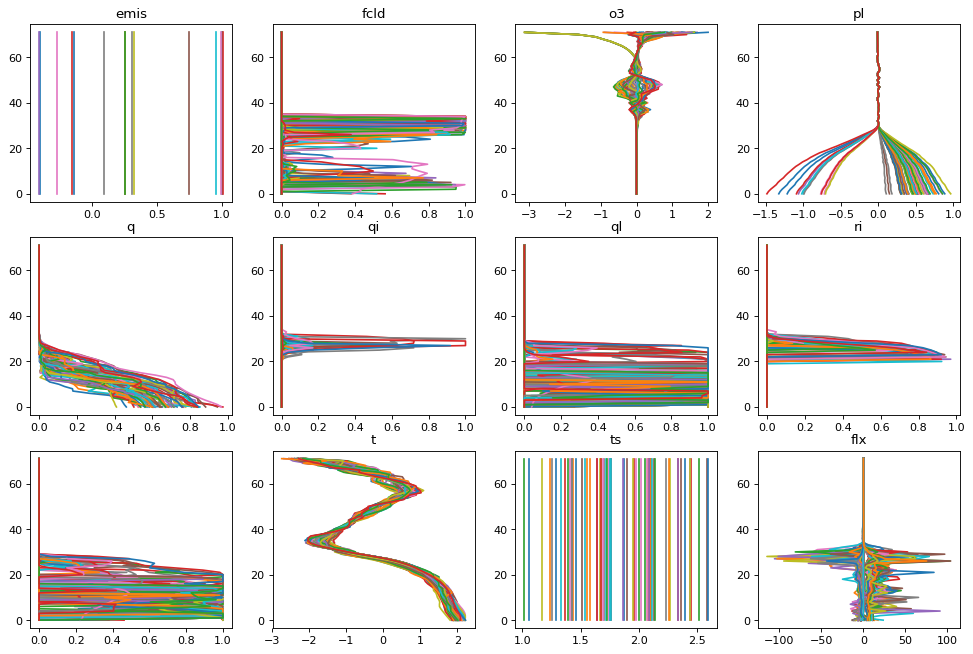

In [67]:
Plot_Batch(x.swapaxes(1,2),y, validation_generator.variables)

In [42]:
class F_and_plots(object):
    def __init__(shape, figsize=(15,10)):
        self.f, self.axes = plt.subplot(shape[0], shape[1], figsize=figsize)
    
    def __getitem__(i):
        return self.axes.flatten()[i]


def Show_triple_diff_separated(y,y0, sep, lev=72, j = 0):
    f = plt.figure( figsize=(15,8) )
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        plt.plot(np.flip(y[:,:,i].T[:sep,j]) , np.arange(sep))
        plt.plot(np.flip(y0[:,:,i].T[:sep,j]) , np.arange(sep))
        ax.legend(["truth", "pred"])
        #
        ax = plt.subplot(1,3,i+1)
        plt.plot(np.flip(y[:,:,i].T[sep:,j]) , np.arange(lev-sep))
        plt.plot(np.flip(y0[:,:,i].T[sep:,j]) , np.arange(lev-sep))
        ax.legend(["truth", "pred"])

In [ ]:
import matplotlib.pyplot as plt

def multipred(models,x):
    bs = x.shape[0]
    yp = np.zeros((len(models),bs,73))
    for i,model in enumerate(models):
        yp[i,:,:]=model.predict(x)
    return(yp)

testsize = 128*4
for x0,y0 in test_generator( (x,y), batch_size=testsize, nb=1):
    data_test = (x0,y0)

ytruth = data_test[1]
xtest = data_test[0].copy() 
xtest1 = data_test[0].copy() 
xtest2 = data_test[0].copy()
xtest3 = data_test[0].copy()

xtest1 *=0
xtest2[:,:,1] *= 0
xtest3[:,:,2] *= 0

ypred = multipred(models,xtest)
ypred1 = multipred(models,xtest1)
ypred2 = multipred(models,xtest2)
ypred3 = multipred(models,xtest3)

def double_mean_squared(y_true, y_pred):
    fist_loss   =  K.mean(K.square(y_pred - y_true), axis=-1)
    second_loss =  x[:, :1]
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
return K.mean(K.square(first_log - second_log), axis=-1)

